In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.externals import joblib

from helpfunction import sciNot

%matplotlib inline
gr      = 1.618

In [2]:
min_dedx_hits=3

# Tracks

In [3]:
dataset = pd.read_pickle('../Input/XGBoost/trackFrame_3.pckl')

In [4]:
dataset.head()

,predict_cos,predict_em,predict_mu,predict_p,predict_pi,track_dedx,track_dedx_avg,track_dedx_hits,track_pca,true_e_cl,track_containment,track_is_daughter,track_length,track_sh_daughter,track_tr_daughter,track_vtx,track_vtx_end,true_e,true_mu
0,0.000202,0.001025,0.001275,0.996582,0.000859,4.167077,23.055122,6.0,0.983398,False,True,False,22.408168,False,False,0.633995,22.985101,False,False
1,0.986328,0.000062,0.007092,0.005074,0.001274,2.015457,6.484311,4.0,0.999512,False,False,False,148.071002,False,False,89.654548,97.150791,False,True
2,0.041443,0.004982,0.353027,0.004162,0.596191,1.641323,5.029923,9.0,0.998047,False,True,False,40.174437,True,False,0.946709,41.110578,False,False
3,0.000818,0.020157,0.011948,0.935547,0.031311,3.643736,15.902322,11.0,0.994141,False,True,False,15.305866,False,True,0.118826,15.218639,False,False
4,0.000161,0.000696,0.002705,0.995117,0.001134,4.301776,15.734635,12.0,0.923828,False,True,True,10.571972,False,False,15.771400,26.065605,False,False


In [5]:
# For now, quick fix: require at least two hits in track_dedx_hits, otherwise track_dedx is nonsence.
dataset_cleaned = dataset[dataset['track_dedx_hits']>=min_dedx_hits]
dataset_cleaned.head()
print(dataset_cleaned.columns)

Index(['predict_cos', 'predict_em', 'predict_mu', 'predict_p', 'predict_pi',
       'track_dedx', 'track_dedx_avg', 'track_dedx_hits', 'track_pca',
       'true_e_cl', 'track_containment', 'track_is_daughter', 'track_length',
       'track_sh_daughter', 'track_tr_daughter', 'track_vtx', 'track_vtx_end',
       'true_e', 'true_mu'],
      dtype='object')


In [6]:
seed = 7
test_size = 0.33

X=dataset_cleaned.drop(columns=['true_e','true_mu','true_e_cl'])
X=X.as_matrix()
Y_mu=dataset_cleaned['true_mu']
Y_e=dataset_cleaned['true_e']
Y_cle = dataset_cleaned['true_e_cl']

In [7]:
# fit model no training data
X_train, X_test, y_train, y_test_mu = train_test_split(X, Y_mu, test_size=test_size, random_state=seed)
model = XGBClassifier()
model.fit(X_train, y_train)
print(classification_report(y_test_mu, model.predict(X_test)))
joblib.dump(model, 'model_tr_mu.pkl') 
y_pred_mu = model.predict_proba(X_test)

/home/wouter/anaconda3/envs/mlenv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


             precision    recall  f1-score   support

      False       0.91      0.90      0.90     36569
       True       0.91      0.92      0.91     40989

avg / total       0.91      0.91      0.91     77558



In [8]:
# fit model no training data
X_train, X_test, y_train, y_test_e = train_test_split(X, Y_e, test_size=test_size, random_state=seed)
model = XGBClassifier()
model.fit(X_train, y_train)
print(classification_report(y_test_e,model.predict(X_test)))
joblib.dump(model, 'model_tr_e.pkl') 
y_pred_e = model.predict_proba(X_test)

/home/wouter/anaconda3/envs/mlenv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


             precision    recall  f1-score   support

      False       0.98      1.00      0.99     75773
       True       0.78      0.11      0.19      1785

avg / total       0.97      0.98      0.97     77558



In [9]:
# fit model no training data
X_train, X_test, y_train, y_test_cle = train_test_split(X, Y_cle, test_size=test_size, random_state=seed)
model = XGBClassifier()
model.fit(X_train, y_train)
print(classification_report(y_test_cle, model.predict(X_test)))
joblib.dump(model, 'model_tr_cle.pkl') 
y_pred_cle = model.predict_proba(X_test)

/home/wouter/anaconda3/envs/mlenv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


             precision    recall  f1-score   support

      False       0.99      1.00      0.99     76540
       True       0.71      0.15      0.24      1018

avg / total       0.99      0.99      0.98     77558



In [10]:
y_pred_e[y_test_e==1][:,0]

array([0.39711756, 0.9877159 , 0.4221462 , ..., 0.363622  , 0.88983047,
       0.97733617], dtype=float32)

Cut value: 0.07 removes 99.5 % of muon tagged tracks and 38.7 % of not-muon tagged tracks.
Cut value: 0.36 keeps 19.1 % of electron tagged tracks and 0.3 % of not-electron tagged tracks.
Cut value: 0.4 keeps 24.1 % of closest electron tagged tracks and 0.2 % of not-closest-electron tagged tracks.


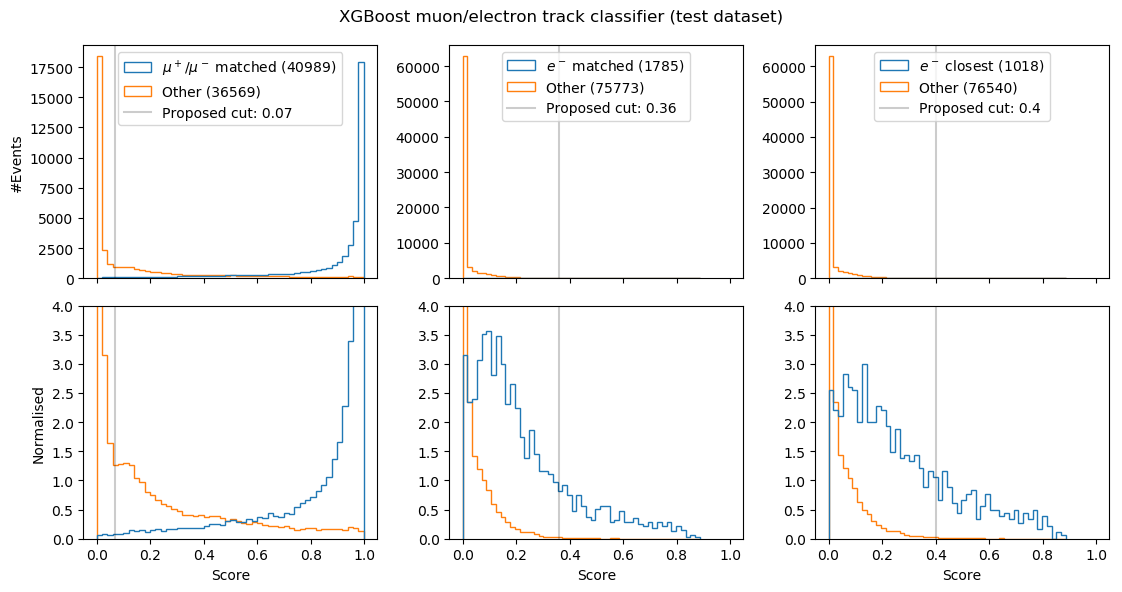

In [11]:
# XGB classification

plt.style.use('default')
fig,ax=plt.subplots(ncols=3,nrows=2,figsize=(7*gr,6),sharex=True)
plt.suptitle(r'XGBoost muon/electron track classifier (test dataset)')
N=50
muon_cut = 0.07
electron_cut=0.36
close_e_cut=0.4

# Electron track classification
arr_e  = y_pred_e[y_test_e==1][:,1]
arr_ne = y_pred_e[y_test_e==0][:,1]

# Electron track classification
arr_cl_e  = y_pred_e[y_test_cle==1][:,1]
arr_cl_ne = y_pred_e[y_test_cle==0][:,1]

# Muon track classification
arr_mu  = y_pred_mu[y_test_mu==1][:,1]
arr_nmu = y_pred_mu[y_test_mu==0][:,1]

label_mu=(r'$\mu^+/\mu^-$ matched ('+str(len(arr_mu))+')','Other ('+str(len(arr_nmu))+')')
label_e=(r'$e^-$ matched ('+str(len(arr_e))+')','Other ('+str(len(arr_ne))+')')
label_cl_e=(r'$e^-$ closest ('+str(len(arr_cl_e))+')','Other ('+str(len(arr_cl_ne))+')')

ax[0][0].hist([arr_mu,arr_nmu],histtype='step', bins=N, fill=False,label=label_mu,normed=False)
ax[0][0].set_ylabel('#Events')
ax[0][0].axvline(x=muon_cut,alpha=.2,color='k',label='Proposed cut: '+str(muon_cut))

ax[1][0].hist([arr_mu,arr_nmu],histtype='step', bins=N, fill=False,label=label_mu,normed=True)
ax[1][0].set_ylim(0,4)
ax[1][0].set_ylabel('Normalised')
ax[1][0].set_xlabel('Score')
ax[1][0].axvline(x=muon_cut,alpha=.2,color='k',label='Proposed cut: '+str(muon_cut))

ax[0][1].hist([arr_e,arr_ne],histtype='step', bins=N, fill=False,label=label_e,density=False)
ax[0][1].axvline(x=electron_cut,alpha=.2,color='k',label='Proposed cut: '+str(electron_cut))

ax[1][1].hist([arr_e,arr_ne],histtype='step', bins=N, fill=False,label=label_e,density=True)
ax[1][1].set_ylim(0,4)
ax[1][1].set_xlabel('Score')
ax[1][1].axvline(x=electron_cut,alpha=.2,color='k',label='Proposed cut: '+str(electron_cut))

ax[0][2].hist([arr_cl_e,arr_cl_ne],histtype='step', bins=N, fill=False,label=label_cl_e,density=False)
ax[0][2].axvline(x=close_e_cut,alpha=.2,color='k',label='Proposed cut: '+str(close_e_cut))

ax[1][2].hist([arr_cl_e,arr_cl_ne],histtype='step', bins=N, fill=False,label=label_cl_e,density=True)
ax[1][2].set_ylim(0,4)
ax[1][2].set_xlabel('Score')
ax[1][2].axvline(x=close_e_cut,alpha=.2,color='k',label='Proposed cut: '+str(close_e_cut))

#offset=0.05
handles, labels = ax[0][0].get_legend_handles_labels()
ax[0][0].legend(handles[::-1], labels[::-1],loc='upper center')
handles, labels = ax[0][1].get_legend_handles_labels()
ax[0][1].legend(handles[::-1], labels[::-1],loc='upper center')
handles, labels = ax[0][2].get_legend_handles_labels()
ax[0][2].legend(handles[::-1], labels[::-1],loc='upper center')

plt.tight_layout()
fig.subplots_adjust(top=0.92)
plt.savefig('XGB_track.pdf')

print('Cut value:',muon_cut,'removes', sciNot(sum(arr_mu>muon_cut) / len(arr_mu)*100),'% of muon tagged tracks and',
      sciNot(sum(arr_nmu>muon_cut) / len(arr_nmu)*100),'% of not-muon tagged tracks.')

print('Cut value:',electron_cut,'keeps', sciNot(sum(arr_e>electron_cut) / len(arr_e)*100),'% of electron tagged tracks and',
      sciNot(sum(arr_ne>electron_cut) / len(arr_ne)*100),'% of not-electron tagged tracks.')

print('Cut value:',close_e_cut,'keeps', sciNot(sum(arr_cl_e>close_e_cut) / len(arr_cl_e)*100),'% of closest electron tagged tracks and',
      sciNot(sum(arr_cl_ne>close_e_cut) / len(arr_ne)*100),'% of not-closest-electron tagged tracks.')


In [12]:
print(len(dataset_cleaned.index))
print(dataset_cleaned['true_e'].value_counts())
print(dataset_cleaned['true_mu'].value_counts())
print(dataset_cleaned['track_containment'].value_counts())
print(dataset_cleaned['track_sh_daughter'].value_counts())
print(dataset_cleaned['track_is_daughter'].value_counts())

235023
False    229738
True       5285
Name: true_e, dtype: int64
True     124508
False    110515
Name: true_mu, dtype: int64
True     170671
False     64352
Name: track_containment, dtype: int64
False    210220
True      24803
Name: track_sh_daughter, dtype: int64
False    227891
True       7132
Name: track_is_daughter, dtype: int64


In [13]:
# Question: how many tracks have a muon score of lower than muon cut, 
# have an electron score higher than electron_cut and are not an electron.
print(sum( (y_pred_mu[:,1]<muon_cut)*(y_pred_e[:,1]>electron_cut)*(y_test_e==0)))
print(sum( (y_pred_mu[:,1]<muon_cut)*(y_test_e==0)))


26
22370


/home/wouter/anaconda3/envs/mlenv/lib/python3.6/site-packages/pandas/core/computation/expressions.py:179: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


# Showers

In [14]:
dataset = pd.read_pickle('../Input/XGBoost/showerFrame_3.pckl')

In [15]:
dataset.head()

,shower_dedx,shower_dedx_avg,shower_dedx_hits,shower_length,shower_open_angle,shower_pca,true_e_cl,shower_is_daughter,shower_sh_daughter,shower_tr_daughter,shower_vtx,true_e,true_mu
0,1.902799,2.683623,2.0,135.750000,0.071533,0.964844,True,False,False,False,0.757006,True,False
1,2.649016,22.033020,9.0,123.562500,0.370850,0.895508,True,False,False,False,49.543482,True,False
2,6.948415,32.257373,15.0,35.812500,0.354248,0.890137,False,False,False,False,62.692193,True,False
3,0.261609,0.332386,4.0,9.601562,0.146118,0.910156,False,False,False,False,0.381499,True,False
4,2.503501,3.964387,6.0,2.417969,0.348145,0.997070,False,False,False,False,3.284274,True,False


In [16]:
# For now, quick fix: require at least two hits in track_dedx_hits, otherwise track_dedx is nonsence.
dataset_cleaned = dataset[dataset['shower_dedx_hits']>=min_dedx_hits]
print(dataset_cleaned.columns)
dataset_cleaned.head()

Index(['shower_dedx', 'shower_dedx_avg', 'shower_dedx_hits', 'shower_length',
       'shower_open_angle', 'shower_pca', 'true_e_cl', 'shower_is_daughter',
       'shower_sh_daughter', 'shower_tr_daughter', 'shower_vtx', 'true_e',
       'true_mu'],
      dtype='object')


,shower_dedx,shower_dedx_avg,shower_dedx_hits,shower_length,shower_open_angle,shower_pca,true_e_cl,shower_is_daughter,shower_sh_daughter,shower_tr_daughter,shower_vtx,true_e,true_mu
1,2.649016,22.033020,9.0,123.562500,0.370850,0.895508,True,False,False,False,49.543482,True,False
2,6.948415,32.257373,15.0,35.812500,0.354248,0.890137,False,False,False,False,62.692193,True,False
3,0.261609,0.332386,4.0,9.601562,0.146118,0.910156,False,False,False,False,0.381499,True,False
4,2.503501,3.964387,6.0,2.417969,0.348145,0.997070,False,False,False,False,3.284274,True,False
5,2.188481,12.605336,11.0,106.250000,0.151611,0.978027,True,False,False,False,2.164389,True,False


In [17]:
seed = 7
test_size = 0.33

X=dataset_cleaned.drop(columns=['true_e','true_mu','true_e_cl'])
X=X.as_matrix()
Y_mu=dataset_cleaned['true_mu']
Y_e=dataset_cleaned['true_e']
Y_cle = dataset_cleaned['true_e_cl']

In [18]:
# fit model no training data
X_train, X_test, y_train, y_test_e = train_test_split(X, Y_e, test_size=test_size, random_state=seed)
model = XGBClassifier()
model.fit(X_train, y_train)
print(classification_report(y_test_e,model.predict(X_test)))
joblib.dump(model, 'model_sh_e.pkl')
y_pred_e = model.predict_proba(X_test)

/home/wouter/anaconda3/envs/mlenv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


             precision    recall  f1-score   support

      False       0.90      0.97      0.94     53577
       True       0.79      0.47      0.58     10882

avg / total       0.88      0.89      0.88     64459



In [19]:
# fit model no training data
X_train, X_test, y_train, y_test_mu = train_test_split(X, Y_mu, test_size=test_size, random_state=seed)
model = XGBClassifier()
model.fit(X_train, y_train)
print(classification_report(y_test_mu, model.predict(X_test)))
joblib.dump(model, 'model_sh_mu.pkl') 
y_pred_mu = model.predict_proba(X_test)

/home/wouter/anaconda3/envs/mlenv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


             precision    recall  f1-score   support

      False       0.81      0.93      0.87     47025
       True       0.69      0.41      0.52     17434

avg / total       0.78      0.79      0.77     64459



In [20]:
# fit model no training data
X_train, X_test, y_train, y_test_cle = train_test_split(X, Y_cle, test_size=test_size, random_state=seed)
model = XGBClassifier()
model.fit(X_train, y_train)
print(classification_report(y_test_cle, model.predict(X_test)))
joblib.dump(model, 'model_sh_cle.pkl') 
y_pred_cle = model.predict_proba(X_test)

/home/wouter/anaconda3/envs/mlenv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


             precision    recall  f1-score   support

      False       0.97      0.98      0.97     58675
       True       0.78      0.65      0.71      5784

avg / total       0.95      0.95      0.95     64459



Cut value: 0.1 removes 98.1 % of muon tagged shower and 62.4 % of not-muon tagged shower.
Cut value: 0.85 keeps 18.3 % of closest electron tagged shower and 0.2 % of not-closest-electron tagged shower.
Cut value: 0.85 keeps 32.7 % of closest electron tagged shower and 0.4 % of not-closest-electron tagged shower.


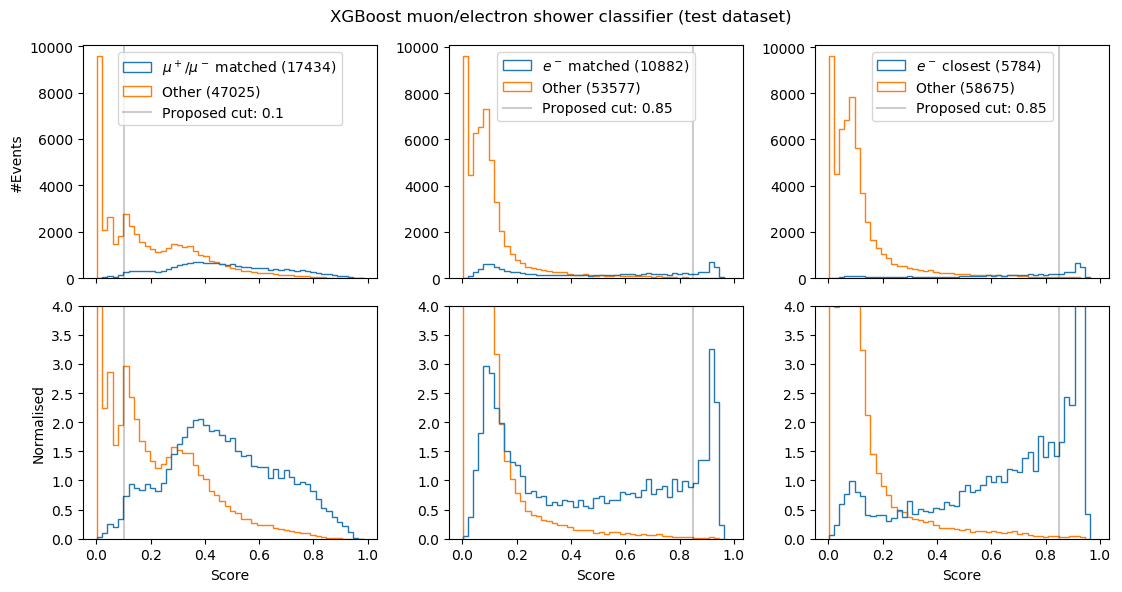

In [21]:
# XGB classification

plt.style.use('default')
fig,ax=plt.subplots(ncols=3,nrows=2,figsize=(7*gr,6),sharex=True)
plt.suptitle(r'XGBoost muon/electron shower classifier (test dataset)')
N=50
muon_cut = 0.1
electron_cut=0.85
close_e_cut=0.85

# Electron track classification
arr_e  = y_pred_e[y_test_e==1][:,1]
arr_ne = y_pred_e[y_test_e==0][:,1]

# Electron track classification
arr_cl_e  = y_pred_e[y_test_cle==1][:,1]
arr_cl_ne = y_pred_e[y_test_cle==0][:,1]

# Muon track classification
arr_mu  = y_pred_mu[y_test_mu==1][:,1]
arr_nmu = y_pred_mu[y_test_mu==0][:,1]

label_mu=(r'$\mu^+/\mu^-$ matched ('+str(len(arr_mu))+')','Other ('+str(len(arr_nmu))+')')
label_e=(r'$e^-$ matched ('+str(len(arr_e))+')','Other ('+str(len(arr_ne))+')')
label_cl_e=(r'$e^-$ closest ('+str(len(arr_cl_e))+')','Other ('+str(len(arr_cl_ne))+')')

ax[0][0].hist([arr_mu,arr_nmu],histtype='step', bins=N, fill=False,label=label_mu,normed=False)
ax[0][0].set_ylabel('#Events')
ax[0][0].axvline(x=muon_cut,alpha=.2,color='k',label='Proposed cut: '+str(muon_cut))

ax[1][0].hist([arr_mu,arr_nmu],histtype='step', bins=N, fill=False,label=label_mu,normed=True)
ax[1][0].set_ylim(0,4)
ax[1][0].set_ylabel('Normalised')
ax[1][0].set_xlabel('Score')
ax[1][0].axvline(x=muon_cut,alpha=.2,color='k',label='Proposed cut: '+str(muon_cut))

ax[0][1].hist([arr_e,arr_ne],histtype='step', bins=N, fill=False,label=label_e,density=False)
ax[0][1].axvline(x=electron_cut,alpha=.2,color='k',label='Proposed cut: '+str(electron_cut))

ax[1][1].hist([arr_e,arr_ne],histtype='step', bins=N, fill=False,label=label_e,density=True)
ax[1][1].set_ylim(0,4)
ax[1][1].set_xlabel('Score')
ax[1][1].axvline(x=electron_cut,alpha=.2,color='k',label='Proposed cut: '+str(electron_cut))

ax[0][2].hist([arr_cl_e,arr_cl_ne],histtype='step', bins=N, fill=False,label=label_cl_e,density=False)
ax[0][2].axvline(x=close_e_cut,alpha=.2,color='k',label='Proposed cut: '+str(close_e_cut))

ax[1][2].hist([arr_cl_e,arr_cl_ne],histtype='step', bins=N, fill=False,label=label_cl_e,density=True)
ax[1][2].set_ylim(0,4)
ax[1][2].set_xlabel('Score')
ax[1][2].axvline(x=close_e_cut,alpha=.2,color='k',label='Proposed cut: '+str(close_e_cut))

#offset=0.05
handles, labels = ax[0][0].get_legend_handles_labels()
ax[0][0].legend(handles[::-1], labels[::-1],loc='upper center')
handles, labels = ax[0][1].get_legend_handles_labels()
ax[0][1].legend(handles[::-1], labels[::-1],loc='upper center')
handles, labels = ax[0][2].get_legend_handles_labels()
ax[0][2].legend(handles[::-1], labels[::-1],loc='upper center')

plt.tight_layout()
fig.subplots_adjust(top=0.92)
plt.savefig('XGB_shower.pdf')

print('Cut value:',muon_cut,'removes', sciNot(sum(arr_mu>muon_cut) / len(arr_mu)*100),'% of muon tagged shower and',
      sciNot(sum(arr_nmu>muon_cut) / len(arr_nmu)*100),'% of not-muon tagged shower.')

print('Cut value:',electron_cut,'keeps', sciNot(sum(arr_e>electron_cut) / len(arr_e)*100),'% of closest electron tagged shower and',
      sciNot(sum(arr_ne>electron_cut) / len(arr_ne)*100),'% of not-closest-electron tagged shower.')

print('Cut value:',close_e_cut,'keeps', sciNot(sum(arr_cl_e>close_e_cut) / len(arr_cl_e)*100),'% of closest electron tagged shower and',
      sciNot(sum(arr_cl_ne>close_e_cut) / len(arr_ne)*100),'% of not-closest-electron tagged shower.')
